# Meta-Learning for XGBoost hyperparameters
## Student: Giovanni Esposito, ID: 12646790


In [2]:
import time
import numpy as np
import pandas as pd
import math

import xgboost as xgb
from sklearn.metrics import roc_auc_score

from utils import get_task_metafeatures, load_test_data, meta_feature_names, \
    default_config, test_ids


In [3]:
meta_feature_names

['data_id',
 'name',
 'status',
 'MajorityClassSize',
 'MaxNominalAttDistinctValues',
 'MinorityClassSize',
 'NumberOfClasses',
 'NumberOfFeatures',
 'NumberOfInstances',
 'NumberOfInstancesWithMissingValues',
 'NumberOfMissingValues',
 'NumberOfNumericFeatures',
 'NumberOfSymbolicFeatures']

## Functions OpenML

### get_task_metafeatures
* As it is written you put the ID of the task and the list of metafeature names in and it just gives you back the metafetures of the task e.g. get_task_metafeatures(16,meta_feature_names)

### test_ids
* The IDs of the tasks we need as test

### meta_feature_names
* The names of the metafeatures

### load_test_data (read documentation of OpenML)
* The data related to the tasks. They are given back in tuple so must find a way to deal with them


In [4]:
#help(get_task_metafeatures)
get_task_metafeatures(16,meta_feature_names)

{'name': 'mfeat-karhunen',
 'status': 'active',
 'MajorityClassSize': 200.0,
 'MaxNominalAttDistinctValues': 10.0,
 'MinorityClassSize': 200.0,
 'NumberOfClasses': 10.0,
 'NumberOfFeatures': 65.0,
 'NumberOfInstances': 2000.0,
 'NumberOfInstancesWithMissingValues': 0.0,
 'NumberOfMissingValues': 0.0,
 'NumberOfNumericFeatures': 64.0,
 'NumberOfSymbolicFeatures': 1.0,
 'data_id': 16}

In [5]:
load_test_data(16)[0].shape

(1800, 64)

### Import data

In [6]:
data = pd.read_csv('xgboost_meta_data.csv')
configs = pd.read_csv('features.csv')

In [95]:
len(data)

3386866

In [7]:
data.sort_values("data_id")

,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc,task_id
1597678,3,kr.vs.kp,1,60,0.291274,0.000204,0.000378,0.001813,0.233868,4,42.25170,0.355684,0.837362,0.428,0.755430,3
1607141,3,kr.vs.kp,5,16,0.010979,2.826100,49.469100,0.001837,0.813627,9,4.08749,0.122839,0.619467,0.267,0.878028,3
1607140,3,kr.vs.kp,9,75,0.183383,0.226297,1.774400,0.003233,0.700562,1,1.55504,0.738503,0.263691,0.381,0.991156,3
1607139,3,kr.vs.kp,7,33,0.001710,0.102649,0.001065,0.054344,0.975130,9,23.01910,0.677148,0.503314,0.436,0.989645,3
1607138,3,kr.vs.kp,5,38,0.001240,5.830380,0.006193,6.580470,0.200497,5,37.06220,0.738828,0.172953,0.310,0.805389,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242062,41169,helena,10,17,0.114867,0.000506,0.000073,0.024436,0.118664,3,30.42540,0.943199,0.557421,57.434,0.853957,168329
1242063,41169,helena,3,93,0.223901,0.696227,21.327300,0.086504,0.885942,14,88.39470,0.389771,0.393395,406.474,0.887306,168329
1242064,41169,helena,5,123,0.123541,0.000033,124.540000,0.007036,0.736045,2,7.68446,0.662849,0.144399,304.615,0.871534,168329
1242066,41169,helena,7,53,0.023228,0.008936,0.460794,11.165500,0.132333,7,2.58301,0.053576,0.121790,109.447,0.818857,168329


In [104]:
data[data['task_id']==16]['data_id'].unique()

array([], dtype=int64)

* We have some redundancies in the data: data_id, task_id and dataset seem to be referred to the dataset, so we can just drop 2 of these 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3386866 entries, 0 to 3386865
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   data_id            int64  
 1   dataset            object 
 2   repl               int64  
 3   num_round          int64  
 4   eta                float64
 5   gamma              float64
 6   lambda             float64
 7   alpha              float64
 8   subsample          float64
 9   max_depth          int64  
 10  min_child_weight   float64
 11  colsample_bytree   float64
 12  colsample_bylevel  float64
 13  timetrain          float64
 14  auc                float64
 15  task_id            int64  
dtypes: float64(10), int64(5), object(1)
memory usage: 413.4+ MB


In [9]:
data.describe()

,data_id,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc,task_id
count,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06,3.386866e+06
mean,1.487676e+04,5.485579e+00,3.768071e+02,1.364768e-01,2.516624e+04,3.853114e+05,9.458420e+06,5.408024e-01,8.186380e+00,6.829419e+01,5.020123e-01,4.965756e-01,5.354496e+01,7.801293e-01,6.212549e+04
std,1.864927e+04,2.866730e+00,5.852917e+02,2.187726e-01,2.321310e+06,3.212279e+07,6.289032e+08,2.621724e-01,4.583650e+00,1.405957e+03,2.866329e-01,2.832278e-01,1.804276e+02,1.921046e-01,7.422715e+04
min,3.000000e+00,1.000000e+00,1.000000e+00,1.872520e-07,1.509140e-11,2.284800e-10,9.497980e-09,1.025330e-03,1.000000e+00,4.708800e-03,1.627010e-03,1.638520e-03,1.280000e-01,1.600000e-01,3.000000e+00
25%,3.070000e+02,3.000000e+00,2.900000e+01,4.831990e-03,5.925450e-04,2.748680e-02,2.795760e-02,3.103300e-01,4.000000e+00,3.106730e+00,2.506690e-01,2.494470e-01,5.120000e-01,5.252738e-01,3.481000e+03
50%,1.486000e+03,5.000000e+00,1.130000e+02,2.771070e-02,1.672600e-02,9.193800e-01,9.318580e-01,5.397120e-01,8.000000e+00,1.087060e+01,5.051320e-01,5.002090e-01,2.118000e+00,8.360680e-01,9.977000e+03
75%,4.090000e+04,8.000000e+00,4.800000e+02,1.678160e-01,3.660700e-01,3.051360e+01,3.583910e+01,7.630590e-01,1.200000e+01,3.688410e+01,7.514810e-01,7.386690e-01,1.673400e+01,9.624545e-01,1.468200e+05
max,4.116900e+04,1.000000e+01,5.917000e+03,9.999580e-01,2.262900e+08,3.574340e+10,4.421560e+10,9.998210e-01,3.200000e+01,1.260770e+05,9.998340e-01,9.999910e-01,2.332337e+03,1.000000e+00,1.687700e+05


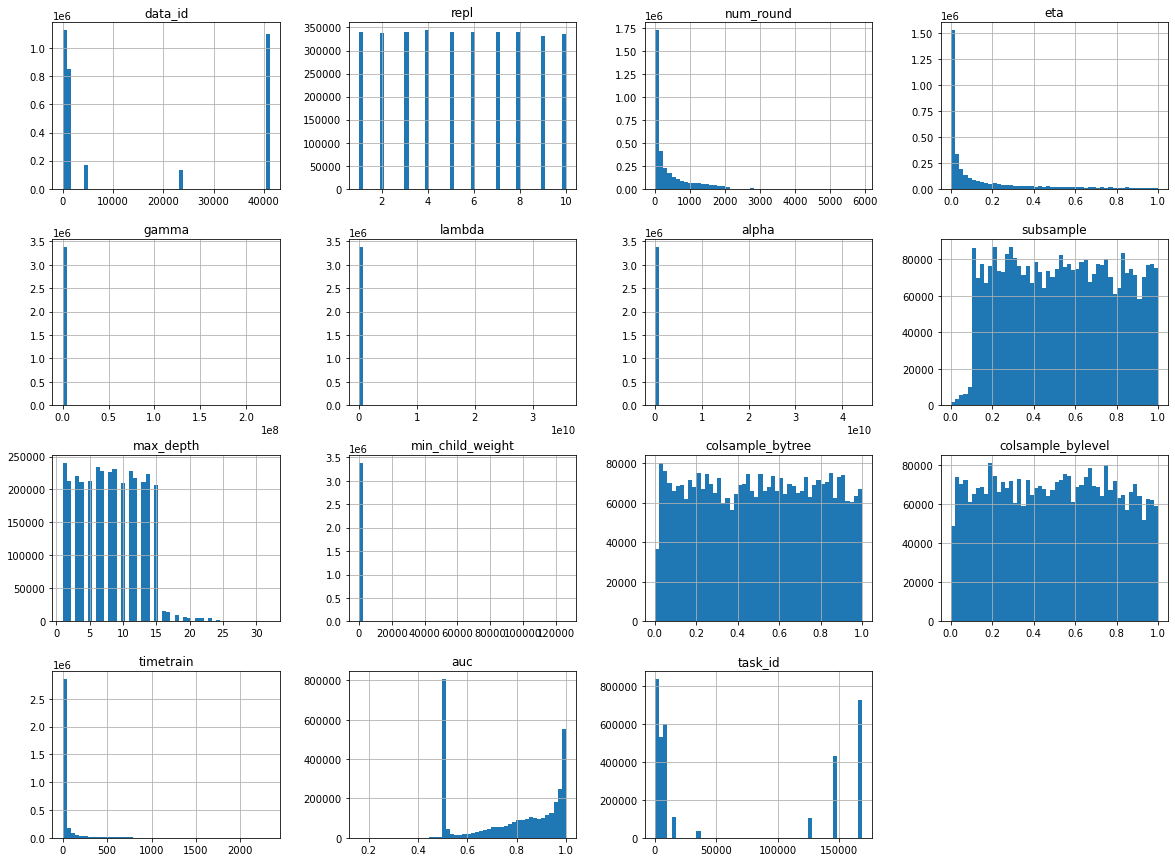

In [10]:
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
corr_matrix = data.corr()
corr_matrix["auc"].sort_values(ascending=False)

auc                  1.000000
subsample            0.144633
timetrain            0.098603
data_id              0.034253
max_depth            0.033791
eta                  0.029444
num_round            0.024408
colsample_bytree     0.019461
colsample_bylevel    0.014918
repl                 0.001115
task_id             -0.007479
gamma               -0.015807
lambda              -0.016585
alpha               -0.021931
min_child_weight    -0.046329
Name: auc, dtype: float64

In [12]:
configs.head()

,data_id,name,version,status,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
0,3,kr-vs-kp,1,active,1669,3.0,1527,2,37,3196,0,0,0,37
1,6,letter,1,active,813,26.0,734,26,17,20000,0,0,16,1
2,11,balance-scale,1,active,288,3.0,49,3,5,625,0,0,4,1
3,12,mfeat-factors,1,active,200,10.0,200,10,217,2000,0,0,216,1
4,14,mfeat-fourier,1,active,200,10.0,200,10,77,2000,0,0,76,1


## Preprocessing data

### Checking for Na and NaN

In [13]:
configs.isna().any(), data.isna().any()

(data_id                               False
 name                                  False
 version                               False
 status                                False
 MajorityClassSize                     False
 MaxNominalAttDistinctValues            True
 MinorityClassSize                     False
 NumberOfClasses                       False
 NumberOfFeatures                      False
 NumberOfInstances                     False
 NumberOfInstancesWithMissingValues    False
 NumberOfMissingValues                 False
 NumberOfNumericFeatures               False
 NumberOfSymbolicFeatures              False
 dtype: bool,
 data_id              False
 dataset              False
 repl                 False
 num_round            False
 eta                  False
 gamma                False
 lambda               False
 alpha                False
 subsample            False
 max_depth            False
 min_child_weight     False
 colsample_bytree     False
 colsample_bylevel  

In [14]:
configs["MaxNominalAttDistinctValues"].isna().sum()

2

* As we can see configs as 2 Nan in the column MaxNominalAttDistinctValues

In [15]:
configs["MaxNominalAttDistinctValues"].describe()

count       92.000000
mean       267.467391
std       1779.671006
min          2.000000
25%          2.000000
50%          5.000000
75%         10.000000
max      15415.000000
Name: MaxNominalAttDistinctValues, dtype: float64

* Since the values are skewed the best strategy is to replace the Nan with the median 

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
configs_num = configs.drop(["name", "status"],axis = 1)
imputer.fit(configs_num)
configs_tr = imputer.transform(configs_num)
configs_tr = pd.DataFrame(configs_tr, columns=configs_num.columns)

## Feature scaling and categorical encoding


## Data

In [17]:
data.head()

,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc,task_id
0,41156,ada,1,6,0.691768,0.149889,89.037500,60.341400,0.473925,10,19.64140,0.180667,0.750369,0.358,0.847134,168767
1,41156,ada,9,194,0.366143,0.000524,11.182800,186.245000,0.924288,10,22.58400,0.176551,0.504884,0.576,0.876018,168767
2,41156,ada,5,383,0.994469,0.001833,0.768332,0.148777,0.618795,11,2.72713,0.785381,0.444095,2.712,0.896378,168767
3,41156,ada,4,17,0.033558,0.000238,0.135247,0.355317,0.156704,7,66.54070,0.987907,0.685637,0.316,0.840724,168767
4,41156,ada,3,8,0.002751,0.007462,0.002056,0.063124,0.365757,4,1.06066,0.187789,0.899083,0.304,0.878050,168767


In [18]:
len(data["data_id"].unique())

94

In [19]:
len(data["task_id"].unique())

94

In [20]:
print(len(data[(data["data_id"]==41156)&((data["task_id"]==168767))]),len(data[(data["data_id"]==41156)]))

37054 37054


* Looks like data_id and task_id are redundant so I eliminate the columns for the latter

In [21]:
data_tr = data.drop("task_id", axis = 1)
data_tr.head()

,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc
0,41156,ada,1,6,0.691768,0.149889,89.037500,60.341400,0.473925,10,19.64140,0.180667,0.750369,0.358,0.847134
1,41156,ada,9,194,0.366143,0.000524,11.182800,186.245000,0.924288,10,22.58400,0.176551,0.504884,0.576,0.876018
2,41156,ada,5,383,0.994469,0.001833,0.768332,0.148777,0.618795,11,2.72713,0.785381,0.444095,2.712,0.896378
3,41156,ada,4,17,0.033558,0.000238,0.135247,0.355317,0.156704,7,66.54070,0.987907,0.685637,0.316,0.840724
4,41156,ada,3,8,0.002751,0.007462,0.002056,0.063124,0.365757,4,1.06066,0.187789,0.899083,0.304,0.878050


## Configs

* Now before feeding configs into an algorithm to produce some ranking we need to standardize the meta features in order to make the algorithm work correctly

* We may also consider exculding some features since Knn is sensible to irrilevant features

In [22]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
encoder = LabelEncoder()

In [23]:
configs_tr.head()

,data_id,version,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
0,3.0,1.0,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
1,6.0,1.0,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0
2,11.0,1.0,288.0,3.0,49.0,3.0,5.0,625.0,0.0,0.0,4.0,1.0
3,12.0,1.0,200.0,10.0,200.0,10.0,217.0,2000.0,0.0,0.0,216.0,1.0
4,14.0,1.0,200.0,10.0,200.0,10.0,77.0,2000.0,0.0,0.0,76.0,1.0


In [24]:
configs_tr[configs_tr["version"]==1]

,data_id,version,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
0,3.0,1.0,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
1,6.0,1.0,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0
2,11.0,1.0,288.0,3.0,49.0,3.0,5.0,625.0,0.0,0.0,4.0,1.0
3,12.0,1.0,200.0,10.0,200.0,10.0,217.0,2000.0,0.0,0.0,216.0,1.0
4,14.0,1.0,200.0,10.0,200.0,10.0,77.0,2000.0,0.0,0.0,76.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
89,41163.0,1.0,2049.0,5.0,1913.0,5.0,2001.0,10000.0,0.0,0.0,2000.0,1.0
90,41164.0,1.0,1927.0,7.0,502.0,7.0,801.0,8237.0,0.0,0.0,800.0,1.0
91,41166.0,1.0,12806.0,10.0,1361.0,10.0,181.0,58310.0,0.0,0.0,180.0,1.0
92,41168.0,1.0,38522.0,4.0,1687.0,4.0,55.0,83733.0,0.0,0.0,54.0,1.0


In [25]:
configs_std = scaler.fit_transform(configs_tr.drop(["data_id","version","MaxNominalAttDistinctValues"], axis = 1))
nam = meta_feature_names.copy()
nam.append("data_id")
nam.remove('MaxNominalAttDistinctValues')
nam

['data_id',
 'name',
 'status',
 'MajorityClassSize',
 'MinorityClassSize',
 'NumberOfClasses',
 'NumberOfFeatures',
 'NumberOfInstances',
 'NumberOfInstancesWithMissingValues',
 'NumberOfMissingValues',
 'NumberOfNumericFeatures',
 'NumberOfSymbolicFeatures',
 'data_id']

In [26]:
met = []
for j in test_ids:
    val= list(get_task_metafeatures(j,nam).values())
    met.append(val[2:13])
query = pd.DataFrame(met, columns = nam[3:13])
query.head()    

,MajorityClassSize,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,data_id
0,200.0,200.0,10.0,65.0,2000.0,0.0,0.0,64.0,1.0,16
1,200.0,200.0,10.0,48.0,2000.0,0.0,0.0,47.0,1.0,22
2,700.0,300.0,2.0,21.0,1000.0,0.0,0.0,7.0,14.0,31
3,1531.0,625.0,6.0,37.0,6430.0,0.0,0.0,36.0,1.0,182
4,214.0,105.0,5.0,20.0,736.0,95.0,448.0,14.0,6.0,188


In [27]:
query_std = scaler.transform(query.drop("data_id", axis = 1))

In [28]:
#cat_trans_tr = encoder.fit_transform(configs_tr["data_id"])
configs_cat = np.array(configs_tr["data_id"],dtype = 'int32').reshape(94,1)
configs_std = np.concatenate((configs_cat,configs_std), axis=1)

In [29]:
configs_std

array([[ 3.00000000e+00, -3.80682683e-01, -1.77838708e-01,
        -3.71410353e-01, -2.83936185e-01, -4.60919862e-01,
        -1.41233492e-01, -1.04207743e-01, -3.00397493e-01,
         1.04275914e+00],
       [ 6.00000000e+00, -4.34759559e-01, -2.77132031e-01,
         1.16320825e+00, -2.96504762e-01,  1.43929641e-01,
        -1.41233492e-01, -1.04207743e-01, -2.90355532e-01,
        -3.57517418e-01],
       [ 1.10000000e+01, -4.67925867e-01, -3.62902429e-01,
        -3.07467911e-01, -3.04045908e-01, -5.53461404e-01,
        -1.41233492e-01, -1.04207743e-01, -2.97887003e-01,
        -3.57517418e-01],
       [ 1.20000000e+01, -4.73485172e-01, -3.43995378e-01,
         1.40129181e-01, -1.70818994e-01, -5.03969136e-01,
        -1.41233492e-01, -1.04207743e-01, -1.64831031e-01,
        -3.57517418e-01],
       [ 1.40000000e+01, -4.73485172e-01, -3.43995378e-01,
         1.40129181e-01, -2.58799032e-01, -5.03969136e-01,
        -1.41233492e-01, -1.04207743e-01, -2.52698182e-01,
        -3.

In [30]:
query_id = np.array(query["data_id"], dtype= "int32")
query_id = query_id.reshape(20,1)
query_std = np.concatenate((query_id ,query_std), axis=1)

In [31]:
configs_std.shape

(94, 10)

In [32]:
query_std.shape

(20, 10)

## Ranking
###   1) We fit a KNN algorithm on the datasets with metafeature (configs) to establish which datasets are more similar to the new ones given in the openML package

In [33]:
#X = configs_tr.drop(["data_id", "version"], axis=1)
#y = configs_tr['data_id']
#X = np.array(X)

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = configs_std[:,1:11]
y = configs_std[:,0]

In [35]:
knn = KNeighborsClassifier(n_neighbors=5,p = 1, weights = "distance")
knn.fit(X,y)

KNeighborsClassifier(p=1, weights='distance')

In [36]:
knn.predict(query_std[:,1:10])

array([1.4000e+01, 1.4000e+01, 5.0000e+01, 1.4750e+03, 4.6900e+02,
       4.0981e+04, 1.0530e+03, 4.0994e+04, 1.4680e+03, 4.4000e+01,
       1.5000e+01, 1.0400e+03, 2.3381e+04, 4.1164e+04, 4.1168e+04,
       5.5400e+02, 1.4610e+03, 4.0670e+04, 4.1157e+04, 1.5900e+03])

In [37]:
distances, algo = knn.kneighbors(query_std[:,1:10],94, return_distance = True)

## Matrix of distances
### After training it makes sense to build a matrix for distances and then computing the average of distances and the median (to see if extreme values have a great impact)

In [38]:
df_dist = pd.DataFrame(distances)
df_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.015073,0.072851,0.129943,0.155030,0.190920,0.198125,0.221065,0.263847,0.265382,0.276584,...,8.074280,8.197342,8.327515,10.330656,12.964645,13.038345,13.088685,15.087847,15.582021,26.449514
1,0.036425,0.051498,0.108590,0.133677,0.212273,0.219478,0.242418,0.244029,0.255231,0.262645,...,8.052927,8.218695,8.306162,10.311817,12.943293,13.016992,13.110038,15.109200,15.568204,26.470867
2,0.177086,0.198620,0.219948,0.230942,0.333015,0.501200,0.525121,0.538816,0.549246,0.550152,...,8.158833,8.246769,9.332116,9.413787,12.906053,12.997336,13.154340,15.596279,16.212575,25.487631
3,0.112102,0.257783,0.270256,0.329243,0.346402,0.362400,0.371458,0.387213,0.389569,0.396131,...,7.494127,7.679987,8.357791,9.759301,12.376951,12.450651,13.164840,15.029496,15.675541,25.932159
4,0.148058,0.242260,0.296375,0.319616,0.344613,0.360998,0.372581,0.373134,0.385457,0.404199,...,8.020808,8.207109,8.861471,9.869843,12.866393,12.957270,12.985438,15.556619,15.679023,26.032658


In [39]:
df_alg = pd.DataFrame(algo)
df_alg.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,4,6,21,63,3,9,75,52,23,65,...,67,87,93,59,62,61,86,38,84,37
1,4,6,21,63,3,9,75,23,65,79,...,67,87,93,59,62,61,86,38,84,37
2,17,10,60,76,7,74,29,12,50,41,...,71,87,93,59,62,61,86,84,38,37
3,43,51,64,58,79,77,25,19,9,26,...,67,87,93,59,62,61,86,84,38,37
4,28,74,18,7,26,27,2,76,29,10,...,88,87,93,59,62,61,86,84,38,37


In [40]:
pd.DataFrame(np.array(df_dist[0]).reshape(1,-1), columns = df_alg[0] )

,4,4,17,43,28,76,34,80,42,15,5,31,60,90,92,30,39,68,86,54
0,0.015073,0.036425,0.177086,0.112102,0.148058,0.103194,0.367709,0.014533,1.296813,0.18771,0.058718,0.256336,0.448446,0.552625,1.830834,0.141424,1.619598,54.529909,4.561624,16.203615


In [41]:
## Calculate mean distances:
rank = []
i = 0
for k in range(0,len(y)):
    for j in range(0,len(y)):
        for i in range(0,len(df_alg)):
            if df_alg[k][i]== j:
                rank.append((k+1,j,df_dist[k][i]))
        

In [42]:
df_r =pd.DataFrame(rank)
df_r.head()

,0,1,2
0,1,4,0.015073
1,1,4,0.036425
2,1,5,0.058718
3,1,15,0.187710
4,1,17,0.177086


In [43]:
import statistics as st
dist_avg = []
rank_median = []
rank_avg = []

for i in range(0,len(y)):
    dist = df_r[df_r[1]==i]
    dist_avg.append(sum(dist[2])/20)
    rank_median.append(st.median(dist[2]))
    rank_avg.append(sum(dist[0])/20)

rd = pd.DataFrame(dist_avg, columns = ["Avg.distance"])
rm = pd.DataFrame(rank_median, columns = ["Median.distance"])
ra = pd.DataFrame(rank_avg, columns = ["Avg.Rank"])   

In [44]:
dist_matrix = rd.join(rm)
dist_matrix = dist_matrix.join(ra)
dist_matrix.sort_values("Avg.distance")

,Avg.distance,Median.distance,Avg.Rank
35,5.940857,0.921534,24.95
33,5.944801,0.899208,24.70
32,5.945171,0.899208,24.85
51,5.947403,1.016935,25.05
36,5.954344,0.909263,26.35
...,...,...,...
61,16.096170,12.815293,85.90
86,17.199142,13.159590,86.45
84,18.597188,15.386602,89.00
38,19.813848,16.067470,88.25


In [45]:
dist_matrix.sort_values("Median.distance")

,Avg.distance,Median.distance,Avg.Rank
32,5.945171,0.899208,24.85
33,5.944801,0.899208,24.70
53,5.962795,0.903607,27.50
36,5.954344,0.909263,26.35
80,5.970828,0.912646,28.85
...,...,...,...
61,16.096170,12.815293,85.90
86,17.199142,13.159590,86.45
84,18.597188,15.386602,89.00
38,19.813848,16.067470,88.25


In [46]:
dist_matrix.sort_values("Avg.Rank")

,Avg.distance,Median.distance,Avg.Rank
33,5.944801,0.899208,24.70
32,5.945171,0.899208,24.85
35,5.940857,0.921534,24.95
51,5.947403,1.016935,25.05
50,5.954611,0.917747,25.60
...,...,...,...
86,17.199142,13.159590,86.45
93,13.118776,8.864612,86.95
38,19.813848,16.067470,88.25
84,18.597188,15.386602,89.00


In [47]:
top5 = dist_matrix.sort_values("Avg.distance")[0:5].index

* The results between mean distance, mean rank and median look pretty close so using one or another shouldn't be so different. I choose to use the top 5 ids by mean

In [48]:
top5

Int64Index([35, 33, 32, 51, 36], dtype='int64')

### I plot AUC vs timetrain to look for possible patterns

In [52]:
#Exclude the extremes so the graph is more clear
cap=data_tr['timetrain'].quantile(0.99)
floor=data_tr['timetrain'].min()
cap, floor

(1052.9167500000003, 0.128)

In [53]:
df1= data_tr[data_tr['timetrain']<data_tr['timetrain'].quantile(0.99)]

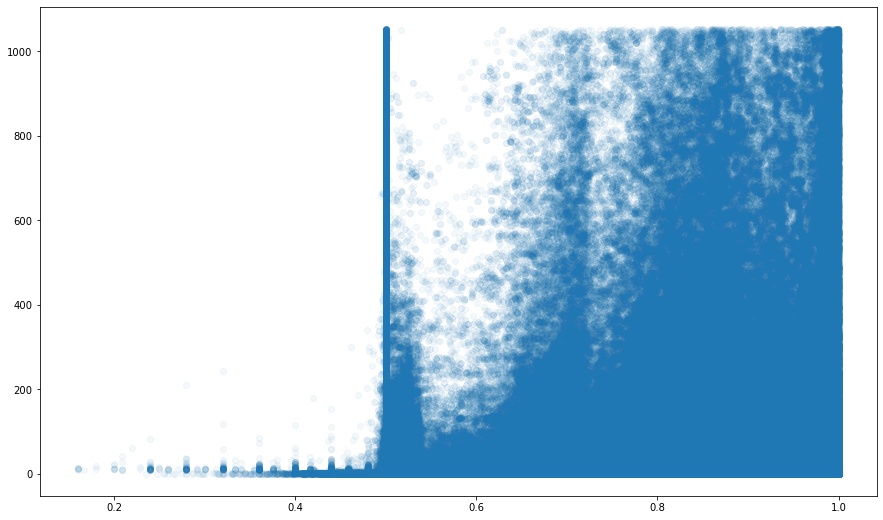

In [54]:
import matplotlib.pyplot as plt

y1 = df1["timetrain"]
x1 = df1['auc']

plt.figure(figsize=(15,9))
plt.scatter(x1, y1, alpha=0.05)

plt.show()

* As we can see there is no clear pattern or relation: the points are generally scattered with higher concentration at lower time and higher AUC. It is useful to note that AUC looks capped at 0.5.

## Algorithm selection
### Once I have selected which datasets are the closest to my new task I select between its tasks the one that performs better
* The performance mesure I am going to use is the adjusted ratio of ratios (ARR) which is a ranking method thet aggregates information concerning accuracy and time. It can be seen as an extension of the success rate ratios (SRR) method. This method is presented in (Brazdil & Soares,2000). It is defined as:
* ARR(p|q) = (SR_p/SR_q)/(1+log(t_p/t_q))
* Once we calculate this for every couple of algorithm we calculate the mean.

In [61]:
i = 0
df_top = pd.DataFrame(columns = data_tr.columns)
while i<5:
    df_top = pd.concat([df_top, data_tr[data_tr["data_id"]==y[top5[i]]]])
    i = i+1
df_top

,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc
1518452,1067,kc1,2,287,0.167816,0.000098,0.041297,1.350900,0.223170,8,1.11994,0.586085,0.648251,0.893,0.804993
1518453,1067,kc1,6,2038,0.153044,0.004377,2.655400,450.561000,0.728295,4,4.40586,0.985228,0.023599,1.728,0.673561
1518454,1067,kc1,4,72,0.009739,0.001445,176.065000,0.596482,0.496458,9,50.31140,0.282294,0.770421,0.236,0.755363
1518455,1067,kc1,1,64,0.018355,5.769730,0.097657,0.007681,0.217287,8,34.97250,0.162808,0.749283,0.491,0.787011
1518456,1067,kc1,3,146,0.026031,0.643062,25.550000,454.240000,0.177679,10,95.13120,0.331945,0.909419,0.299,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291963,1068,pc1,7,375,0.007252,0.528993,0.028361,398.828000,0.326748,4,3.54413,0.698788,0.607173,0.376,0.500000
2291964,1068,pc1,7,11,0.048377,0.121968,11.922200,43.901000,0.914382,3,24.03300,0.276640,0.180538,0.197,0.500000
2291965,1068,pc1,8,170,0.001057,1.774730,0.880065,684.600000,0.317114,14,60.58590,0.906441,0.581361,0.265,0.500000
2291966,1068,pc1,6,676,0.103791,0.258257,0.052887,0.026836,0.956937,13,1.24280,0.290175,0.633734,0.883,0.883495


* The fact of calculating for couple of algorithms is a bit problematic since It may be computationally infeasable. The dimensions of df_top (177871 rows) means that I will need to perform c.a. 177871*2 operations. At first I wanted just to filter for higher value of AUC and lower of timetrain. But It wouldn't have been statistically correct so I decided just to sample from df_top, taking the 5% of observation weighting for AUC value.

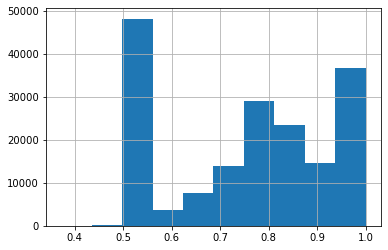

In [116]:
df_top['auc'].hist()
plt.savefig('AUC1')
plt.show()

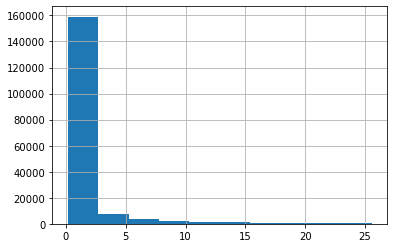

In [127]:
df_top['timetrain'][df_top['timetrain']<df_top['timetrain'].quantile(0.99)].hist()
plt.savefig('TIM1')
plt.show()

In [64]:
df_small = df_top.sample(n = math.floor(len(df_top)/20), weights = "auc", random_state= 12345)

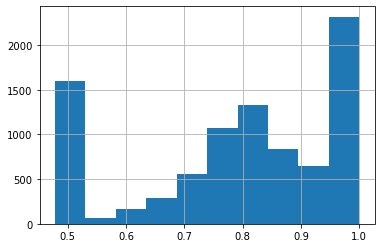

In [128]:
df_small['auc'].hist()
plt.savefig('AUC2')
plt.show()

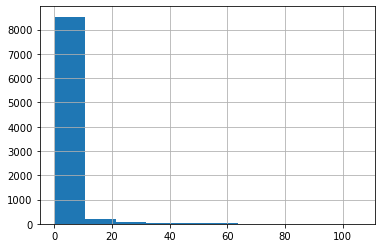

In [129]:
df_small['timetrain'].hist()
plt.savefig('TIM2')
plt.show()

* We obtain a reliable approximation of AUC distribution and also the timetrain distribution looks similar

In [67]:
df_small["data_id"].unique()

array([1068, 1050, 1067, 1497, 1049], dtype=object)

In [122]:
df_small["dataset"].unique()

array(['pc1', 'pc3', 'kc1', 'wall.robot.navigation', 'pc4'], dtype=object)

* Now we can compute the ARR between our configurations

In [81]:
import math
import time

st = time.time()

acc = 0.1
val = np.zeros(len(df_small))
tot, k= 0,0


while k< len(df_small):
        i = 0
        tot = 0
        while i<len(df_small):
            arr =(df_small['auc'].iloc[k]/df_small['auc'].iloc[i])/(1+acc*math.log(df_small['timetrain'].iloc[k]/df_small['timetrain'].iloc[i]))
            tot += arr
            i += 1
        val[k] = tot/len(df_small)
        k = k+1
    
    
en = time.time()

In [82]:
len(val[val!=0])


8893

* I save the dataframes as parquet so I won't need to perform calculations everytime I open the code

In [85]:
import pyarrow.parquet as pq
df1 = pd.DataFrame(val, columns = ["ARR"])
df1.to_parquet("values.parquet")

In [141]:
import pyarrow.parquet as pq
df = pd.read_parquet("values.parquet")
df.head()

,ARR
0,1.084374
1,0.724750
2,1.210800
3,0.761374
4,1.227716


In [142]:
df["ARR"].max()

1.484677221958305

In [147]:
df["ARR"].sort_values(ascending=False)

2980    1.484677
710     1.484588
7361    1.479660
1414    1.471372
3696    1.466379
          ...   
3961    0.486324
1222    0.479353
6526    0.476238
7939    0.457422
4313    0.451666
Name: ARR, Length: 8893, dtype: float64

In [59]:
best = [i for i,x in enumerate(df["ARR"]) if x == df["ARR"].max()]
best

[2980]

In [87]:
val.max()

1.484677221958305

In [68]:
best_conf = df_small.iloc[best, 2:13]
best_conf = best_conf.to_dict('index')[3238239]
best_conf

{'repl': 7,
 'num_round': 1,
 'eta': 0.000199687,
 'gamma': 0.0144773,
 'lambda': 0.00118843,
 'alpha': 0.971001,
 'subsample': 0.186941,
 'max_depth': 7,
 'min_child_weight': 1.54714,
 'colsample_bytree': 0.644196,
 'colsample_bylevel': 0.558417}

In [89]:
default_config

{'n_estimators': 464,
 'eta': 0.0082,
 'subsample': 0.982,
 'max_depth': 11,
 'min_child_weight': 3.3,
 'colsample_bytree': 0.975,
 'colsample_bylevel': 0.9,
 'lambda': 0.06068,
 'alpha': 0.00235,
 'gamma': 0}

In [69]:
import arff
from collections import defaultdict
from typing import List, Tuple, Dict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

import numpy as np
import pandas as pd

np.random.seed(0)


def get_stats(df, cutoff: float, par: int = 10) -> (float, float):
    """
    Simple method to determine Virtual best and Single best performance.
    Expects input data in the ASLib data format.
    :param aslib_data: List of ASlib data.
                       Entries are as follows:
                       [('instance_id', 'STRING'),
                        ('repetition', 'NUMERIC'),
                        ('algorithm', 'STRING'),
                        ('runtime', 'NUMERIC'),
                        ('runstatus', ['ok', 'timeout', 'memout', 'not_applicable', 'crash', 'other'])]
    :param cutoff: The used cutoff as a float
    :param par: The penalization factor (default = 10) if runtime >= cutoff then runtime = PAR * cutoff
    :return: oracle_perf (float), single_best_perf(float)
    """
    #df = pd.DataFrame(aslib_data)  # pandas data frames allow for easy data handling
    #df.columns = ['instance_id', 'repetition', 'algorithm', 'runtime', 'runstatus']  # correctly name the entries
    
    # TODO get virtual_best performance as well as single best performance
    algos = defaultdict(list)  # track individual algorithm performances
    insts = defaultdict(lambda: np.inf)  # track individual instance performances
    algos_a = defaultdict(list)  # track individual algorithm performances
    insts_a = defaultdict(lambda: 0) 
    
    # Alternative by going over a everything line by line
    for line in df.values:
        inst = line[0]
        algo = line[1]
        runt = line[13]
        auc = line[14]
        
        # print(inst, algo, runt, stat)
        insts[inst] = min(insts[inst], runt)  # keep track of the best runtime for each instance
        algos[algo].append(runt)  # keep track of the algorithms runtimes
        insts_a[inst] = max(insts_a[inst], auc) 
        algos_a[algo].append(auc)
    virtual_best = np.mean(list(insts.values()))
    single_best = min(map(lambda x: np.mean(x), algos.values()))
    
    virtual_best_auc = np.mean(list(insts_a.values()))
    single_best_auc = max(map(lambda x: np.mean(x), algos_a.values()))
    return virtual_best, single_best,virtual_best_auc, single_best_auc




In [70]:
get_stats(data_tr,5000,10)

(3.036978723404253, 0.4851206774659576, 0.9495262815285519, 0.9638373564354401)

In [71]:
data_tr["timetrain"].min()

0.128

In [149]:
data_tr[data_tr["timetrain"] == data_tr["timetrain"].min()]


,data_id,dataset,repl,num_round,eta,gamma,lambda,alpha,subsample,max_depth,min_child_weight,colsample_bytree,colsample_bylevel,timetrain,auc
277471,11,balance.scale,4,3,0.001829,3.26188,0.00007,1.27281,0.668392,8,43.4098,0.040638,0.622025,0.128,0.807544


# Testing

In [72]:
from sklearn.metrics import roc_auc_score

class XGBoostTest:
    """Set seed, get train-test data and meta features of task_id"""
    def __init__(self, task_id: int, meta_feature_names: list, seed: int = 12345):
        self.seed = seed
        self.task_id = task_id
        self.train_x, self.train_y, self.test_x, self.test_y, self.nclasses = load_test_data(task_id)
        self.meta_features = get_task_metafeatures(task_id, meta_feature_names)

    """Initialize the xgboost learner based on a hyperparameter configuration"""
    def init_model(self, config: dict, seed: int = None):
        rng = np.random.RandomState(self.seed) if seed is None else np.random.RandomState(seed)
        extra_args = dict(random_state=rng, eval_metric=roc_auc_score)
        if self.nclasses > 2:
            extra_args["objective"] = "multi:softmax"
            extra_args.update({"num_class": self.nclasses})

        model = xgb.XGBClassifier(
            **config,
            **extra_args
        )
        return model

    """
    Evaluate the xbgoost learner by first initializing the model based on a hyperparameter configuration,
    train on train set and evaluate on test set based on AUC
    """
    def evaluate(self, config: dict, seed: int=None):
        model = self.init_model(config, seed)
        train_start = time.time()
        model.fit(self.train_x, self.train_y)
        timetrain = time.time() - train_start
        prediction_prob = model.predict_proba(self.test_x)
        if self.nclasses == 2:
            # handling binary classification
            prediction_prob = prediction_prob[:, 1]
        auc = roc_auc_score(self.test_y, prediction_prob, multi_class="ovr")
        return auc, timetrain


In [73]:
# excluding the ids 146825 and 168332 to fasten the process
new_ids = test_ids.copy()
new_ids.remove(146825)
new_ids.remove(168332)
print(new_ids)

[16, 22, 31, 2074, 2079, 3493, 3907, 3913, 9950, 9952, 9971, 10106, 14954, 14970, 146212, 167119, 167125, 168336]


In [75]:
if __name__ == "__main__":
    seed = 12345
    default = []
    for i in range(0,len(new_ids)):
        task_id = new_ids[i]
        print(f"Task ID: {task_id}")
        # initialize the interface to the XGBoost test tasks
        objective = XGBoostTest(task_id, meta_feature_names = meta_feature_names, seed = seed)
        meta_features = objective.meta_features
        print(f"The meta features of task ID {task_id} are:")
        print(meta_features)
        # modelling and evaluating the default config
        auc, timetrain = objective.evaluate(default_config)
        default.append((auc,timetrain))
        print(f"The default config scored an AUC of {auc} in {timetrain}s on task ID {task_id}.")

Task ID: 16
The meta features of task ID 16 are:
{'name': 'mfeat-karhunen', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 65.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 64.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 16}
The default config scored an AUC of 0.9974166666666665 in 29.283215045928955s on task ID 16.
Task ID: 22
The meta features of task ID 22 are:
{'name': 'mfeat-zernike', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 48.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 47.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 22}
The default config scored an AUC of 0.9735555555555555 in 27.0

The default config scored an AUC of 0.9690109958648315 in 42.49704122543335s on task ID 167119.
Task ID: 167125
The meta features of task ID 167125 are:
{'name': 'Internet-Advertisements', 'status': 'active', 'MajorityClassSize': 2820.0, 'MaxNominalAttDistinctValues': 2.0, 'MinorityClassSize': 459.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 1559.0, 'NumberOfInstances': 3279.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 3.0, 'NumberOfSymbolicFeatures': 1556.0, 'data_id': 40978}
The default config scored an AUC of 0.9663120567375887 in 81.07015943527222s on task ID 167125.
Task ID: 168336
The meta features of task ID 168336 are:
{'name': 'kick', 'status': 'active', 'MajorityClassSize': 64007.0, 'MinorityClassSize': 8976.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 33.0, 'NumberOfInstances': 72983.0, 'NumberOfInstancesWithMissingValues': 69709.0, 'NumberOfMissingValues': 149271.0, 'NumberOfNumericFeatures': 14.0, 'NumberOfSymbo

In [76]:
if __name__ == "__main__":
    seed = 12345
    best = []
    for i in range(0,len(new_ids)):
        task_id = new_ids[i]
        print(f"Task ID: {task_id}")
        # initialize the interface to the XGBoost test tasks
        objective = XGBoostTest(task_id, meta_feature_names = meta_feature_names, seed = seed)
        meta_features = objective.meta_features
        print(f"The meta features of task ID {task_id} are:")
        print(meta_features)
        # modelling and evaluating the default config
        auc, timetrain = objective.evaluate(best_conf)
        best.append((auc,timetrain))
        print(f"The best config scored an AUC of {auc} in {timetrain}s on task ID {task_id}.")

Task ID: 16
The meta features of task ID 16 are:
{'name': 'mfeat-karhunen', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 65.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 64.0, 'NumberOfSymbolicFeatures': 1.0, 'data_id': 16}
[11:51:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_round", "repl" } are not used.

The best config scored an AUC of 0.99 in 1.172095775604248s on task ID 16.
Task ID: 22
The meta features of task ID 22 are:
{'name': 'mfeat-zernike', 'status': 'active', 'MajorityClassSize': 200.0, 'MaxNominalAttDistinctValues': 10.0, 'MinorityClassSize': 200.0, 'NumberOfClasses': 10.0, 'NumberOfFeatures': 48.0, 'NumberOfInstances': 2000.0, 'NumberOfInstancesWithMissi

The best config scored an AUC of 0.99929676511955 in 0.3799750804901123s on task ID 10106.
Task ID: 14954
The meta features of task ID 14954 are:
{'name': 'cylinder-bands', 'status': 'active', 'MajorityClassSize': 312.0, 'MaxNominalAttDistinctValues': 71.0, 'MinorityClassSize': 228.0, 'NumberOfClasses': 2.0, 'NumberOfFeatures': 40.0, 'NumberOfInstances': 540.0, 'NumberOfInstancesWithMissingValues': 263.0, 'NumberOfMissingValues': 999.0, 'NumberOfNumericFeatures': 18.0, 'NumberOfSymbolicFeatures': 22.0, 'data_id': 6332}
[11:51:43] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "num_round", "repl" } are not used.

The best config scored an AUC of 0.8681626928471249 in 0.07232189178466797s on task ID 14954.
Task ID: 14970
The meta features of task ID 14970 are:
{'name': 'har', 'status': 'active', 'MajorityClassSize': 1944.0, 'MaxNominalAttDistinctValues': 6.0, 'MinorityClassSize

In [83]:
df_default = pd.DataFrame(default, columns = ["AUC","timetrain"])
df_Evbest =  pd.DataFrame(best, columns = ["AUC","timetrain"])
df_default.to_parquet("DefaultEval.parquet")
df_Evbest.to_parquet("BestEval.parquet")

In [150]:
df_default

,AUC,timetrain
0,0.997417,29.283215
1,0.973556,27.072123
2,0.848095,1.240850
3,0.989274,21.833605
4,0.914557,3.824720
5,0.977381,0.448396
6,0.987234,3.577945
7,0.904762,0.500234
8,0.996221,45.299525
9,0.957029,3.352330


In [152]:
df_Evbest

,AUC,timetrain
0,0.990000,1.172096
1,0.963417,1.306336
2,0.785238,0.096296
3,0.981161,1.858960
4,0.894604,0.333550
5,0.644048,0.061832
6,0.749468,0.239909
7,0.854978,0.056806
8,0.979697,2.985063
9,0.907010,0.264832


In [86]:
from scipy.stats import gmean
import math
def arr(x,y,acc):
    tot, k= 0,0
    val = np.zeros(len(x))
    while k<len(x):
        i = 0
        tot = 0
        while i<len(y):
            arr =(x["AUC"][k]/x["AUC"][i])/(1+acc*math.log(x["timetrain"][k]/y["timetrain"][i]))
            tot += arr
            i += 1
        val[k] = tot/len(x)
        k = k+1
    return(val)

In [131]:
np.mean(arr(df_Evbest,df_default,0.1))

1.787781972445892

In [132]:
np.mean(arr(df_default,df_Evbest,0.1))

0.8373882241046104

In [133]:
np.mean(arr(df_Evbest,df_default,0.01))

1.0440801152361288

In [134]:
np.mean(arr(df_default,df_Evbest,0.01))

0.9850434299233002

In [136]:
np.mean(arr(df_Evbest,df_default,0.001))

1.0205205349282278

In [135]:
np.mean(arr(df_default,df_default,0.001))

1.0116109626453527

In [90]:
df_Evbest["AUC"]>df_default["AUC"]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
Name: AUC, dtype: bool

In [93]:
df_Evbest["AUC"]-df_default["AUC"]

0    -0.007417
1    -0.010139
2    -0.062857
3    -0.008113
4    -0.019953
5    -0.333333
6    -0.237766
7    -0.049784
8    -0.016524
9    -0.050018
10    0.057423
11    0.000000
12   -0.042076
13   -0.001638
14   -0.000055
15   -0.080910
16   -0.015957
17   -0.033992
Name: AUC, dtype: float64

In [91]:
df_Evbest["timetrain"]<df_default["timetrain"]

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
Name: timetrain, dtype: bool

In [94]:
df_Evbest["timetrain"]-df_default["timetrain"]

0     -28.111119
1     -25.765787
2      -1.144555
3     -19.974645
4      -3.491170
5      -0.386564
6      -3.338036
7      -0.443428
8     -42.314462
9      -3.087499
10     -0.545162
11    -11.523536
12     -0.699577
13   -750.873912
14    -44.528125
15    -38.784152
16    -76.986002
17   -333.254922
Name: timetrain, dtype: float64